<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Naser Kazemi
### Student Number : 99102059
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [100]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import os
import copy
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML/"Q3. NN with PyTorch"

[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/Q3. NN with PyTorch'
/content


In [ ]:
%cd 'Q3. NN with PyTorch'

[Errno 2] No such file or directory: 'Q3. NN with PyTorch'
/content


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [ ]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


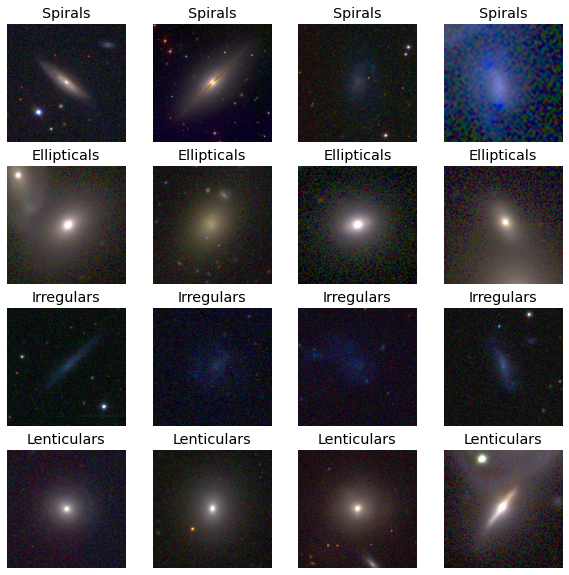

In [92]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
classes = ['Spirals', 'Ellipticals', 'Irregulars', 'Lenticulars']

sample_names = {}
for c in classes:
    sample_names[c] = df[df['class_name'] == c]['name'].values[:4].tolist()


fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, c in enumerate(classes):
    for j, name in enumerate(sample_names[c]):
        img = plt.imread('./efigi-1.6/png/' + name + '.png')
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(c)


# Define Dataset (20 Points)

In [93]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, train=True, transform=None, **kwargs):
        # load data
        super().__init__(**kwargs)
        self.data_dir = './efigi-1.6/png/'
        self.train = train
        self.images_name = sorted(entry.name.replace('.png', '') for entry in os.scandir(self.data_dir))
        # if self.train:
        #     self.images_name = self.images_name[:int(len(self.images_name) * 0.8)]
        # else:
        #     self.images_name = self.images_name[int(len(self.images_name) * 0.8):]

        self.attributes = prepare_data('./efigi-1.6/EFIGI_attributes.txt')
        self.classes = ['Spirals', 'Ellipticals', 'Irregulars', 'Lenticulars']
        self.data = [[self.data_dir + name + '.png', self.attributes[self.attributes['name'] == name]
                      ['class_name'].values[0]] for name in self.images_name]
        self.image_dim = ()
        self.transform = transform
        
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # load image
        img = plt.imread(self.data[idx][0])
        # convert image to tensor
        img = torch.tensor(img, dtype=torch.float32)
        if self.transform:
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            img = img.permute(1, 2, 0)
        
        # convert class name to class index
        label = self.classes.index(self.data[idx][1])
        # convert class index to tensor
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [94]:
#prepare data
transform = transforms.Compose([transforms.Resize((32, 32))])

dataset = GalaxyDataSet(transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


batch_size = 50

# train and test data
train_data, test_data = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

val_data, train_data = random_split(train_data, [int(len(train_data) * 0.2), len(train_data) - int(len(train_data) * 0.2)])
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Define Model (20 Points)

In [ ]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self, input_dim,hidden,out):
        super(ClassifierModel, self).__init__()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(input_dim, hidden)
        self.layer2 = nn.Linear(hidden, hidden)
        self.layer3 = nn.Linear(hidden, out)
        
    def forward(self,x): 
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x= self.relu(self.layer3(x))
        return x

# Train Model (30 Points)

In [95]:
model = ClassifierModel(3*32*32, 100, 4)
model.to(device)

# define hyper parameters
learning_rate = 0.001
batch_size = 50
num_epochs = 30

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# define accuracy function
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    return torch.sum(y_pred == y_true).item() / len(y_true)

In [96]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

# define train function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)
            # labels = labels.view(labels.shape[0], -1)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # print epoch metrics
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.\
              format(epoch+1, num_epochs, loss.item(), accuracy(outputs, labels)))
                
        # save epoch metrics
        
        train_loss.append(loss.item())
        train_acc.append(accuracy(outputs, labels))
        
        # evaluate model on validation set
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                images = images.view(images.shape[0], -1)
                # labels = labels.view(labels.shape[0], -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        # print validation metrics
        print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.\
                format(loss.item(), accuracy(outputs, labels)))

        # save epoch metrics
        val_loss.append(loss.item())
        val_acc.append(accuracy(outputs, labels))
        
        
        # save best model
        if best_model is None or val_loss[-1] < min(val_loss):
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'best_model.pt')
            print('Best model updated')
            
    # load best model
    model.load_state_dict(best_model)
    return model, train_loss, val_loss, train_acc, val_acc

In [ ]:
# train model
model, train_loss, val_loss, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/30], Loss: 0.4548, Accuracy: 0.88%
Validation Loss: 0.3486, Validation Accuracy: 0.92%
Best model updated
Epoch [2/30], Loss: 0.9947, Accuracy: 0.56%
Validation Loss: 0.4173, Validation Accuracy: 0.92%
Epoch [3/30], Loss: 0.8199, Accuracy: 0.69%
Validation Loss: 0.5930, Validation Accuracy: 0.77%
Epoch [4/30], Loss: 0.8583, Accuracy: 0.56%
Validation Loss: 0.8242, Validation Accuracy: 0.77%
Epoch [5/30], Loss: 0.9468, Accuracy: 0.56%
Validation Loss: 0.5760, Validation Accuracy: 0.77%
Epoch [6/30], Loss: 0.5061, Accuracy: 0.88%
Validation Loss: 0.1479, Validation Accuracy: 0.92%
Epoch [7/30], Loss: 0.4299, Accuracy: 0.94%
Validation Loss: 0.2447, Validation Accuracy: 0.92%
Epoch [8/30], Loss: 0.3811, Accuracy: 0.94%
Validation Loss: 0.2255, Validation Accuracy: 0.92%
Epoch [9/30], Loss: 0.2781, Accuracy: 0.88%
Validation Loss: 0.3368, Validation Accuracy: 0.77%
Epoch [10/30], Loss: 0.3868, Accuracy: 0.75%
Validation Loss: 0.5116, Validation Accuracy: 0.69%
Epoch [11/30], Loss:

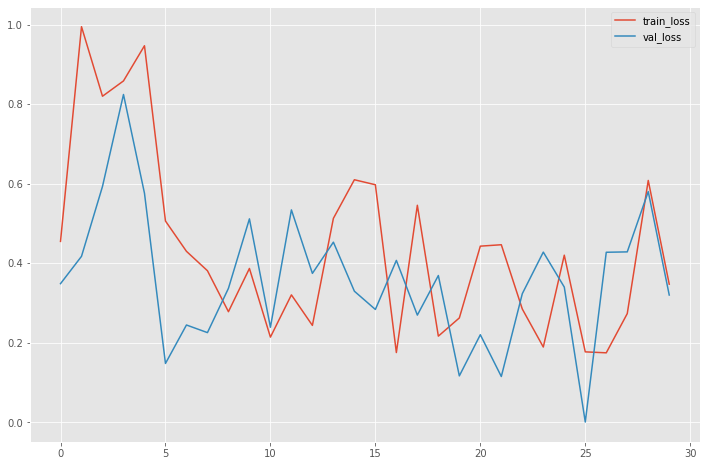

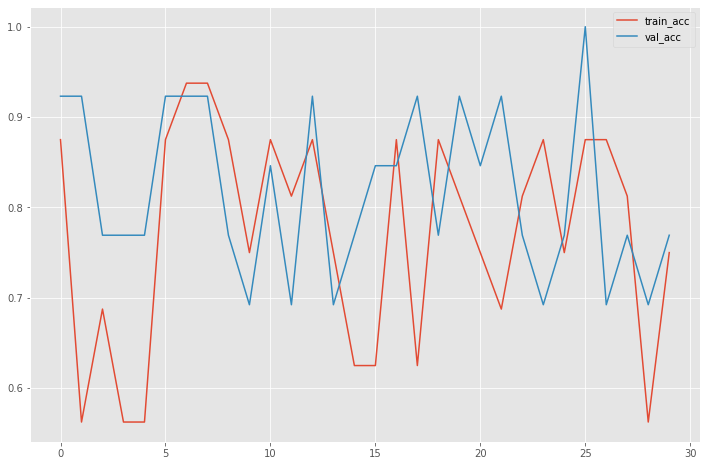

In [99]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.show()


# Test Model (20)

Test Loss: 1.3593, Test Accuracy: 0.72%


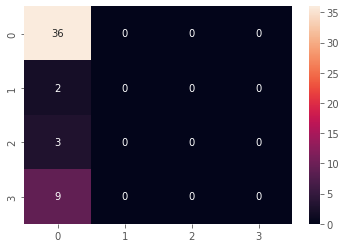

Test Loss: 1.3586, Test Accuracy: 0.74%


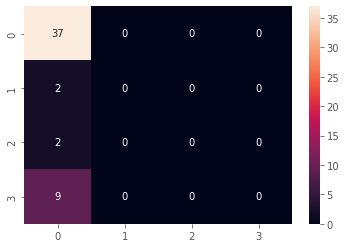

Test Loss: 1.3593, Test Accuracy: 0.74%


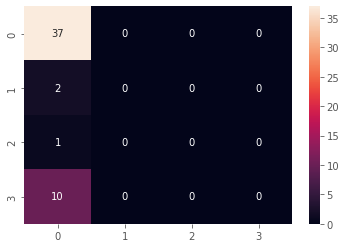

Test Loss: 1.3581, Test Accuracy: 0.80%


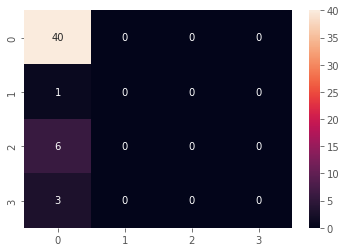

Test Loss: 1.3612, Test Accuracy: 0.72%


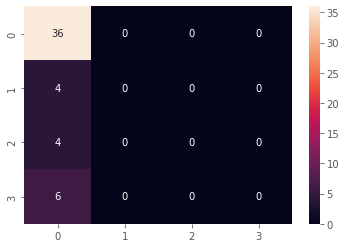

Test Loss: 1.3636, Test Accuracy: 0.68%


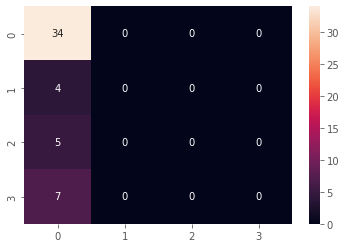

Test Loss: 1.3594, Test Accuracy: 0.76%


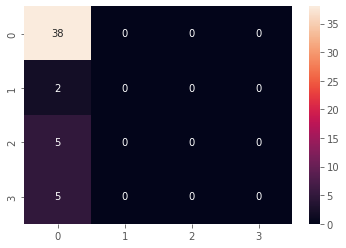

Test Loss: 1.3598, Test Accuracy: 0.78%


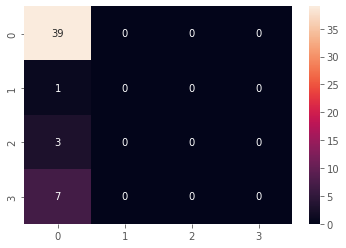

Test Loss: 1.3647, Test Accuracy: 0.68%


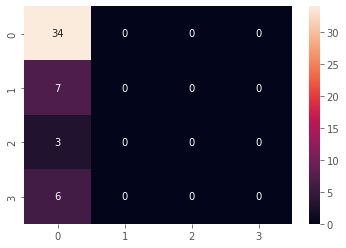

Test Loss: 1.3586, Test Accuracy: 0.76%


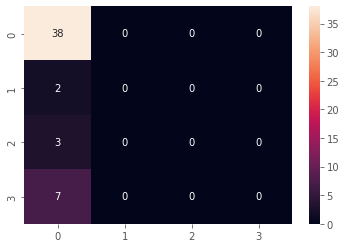

Test Loss: 1.3557, Test Accuracy: 0.84%


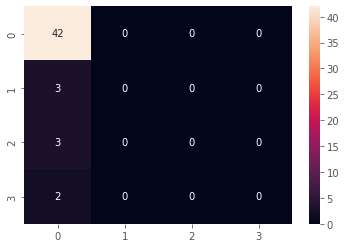

Test Loss: 1.3642, Test Accuracy: 0.66%


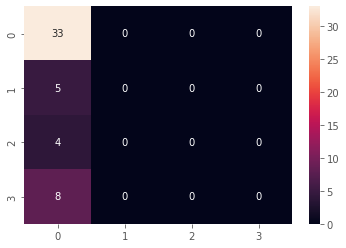

Test Loss: 1.3652, Test Accuracy: 0.68%


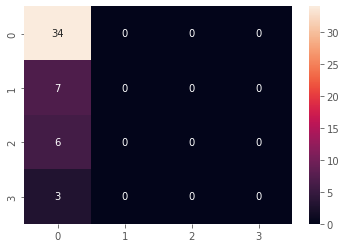

Test Loss: 1.3569, Test Accuracy: 0.80%


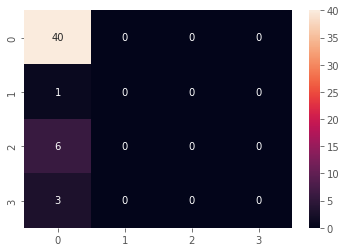

Test Loss: 1.3584, Test Accuracy: 0.74%


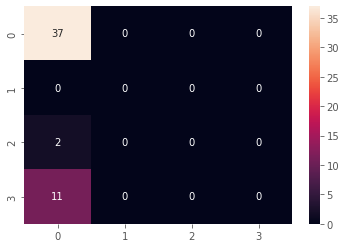

Test Loss: 1.3640, Test Accuracy: 0.68%


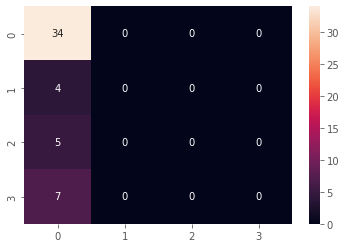

Test Loss: 1.3576, Test Accuracy: 0.80%


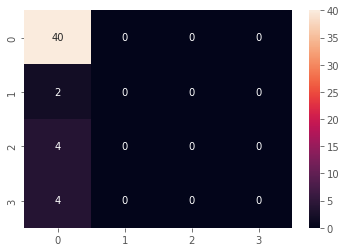

Test Loss: 1.3554, Test Accuracy: 0.79%


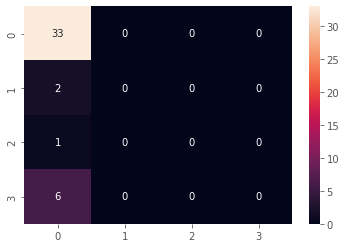

In [101]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################


def confusion_matrix(y_true, y_pred):
    cm = np.zeros((4, 4), dtype=np.int32)
    for i in range(len(y_true)):
        cm[y_true[i]][y_pred[i]] += 1
    return cm


# test model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 3*32*32)
        outputs = model(images)
        loss = criterion(outputs, labels)
            
        # save epoch metrics
        test_loss = loss.item()
        test_acc = accuracy(outputs, labels)
        
        # print validation metrics
        print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.\
                format(loss.item(), accuracy(outputs, labels)))
        
        # plot confusion matrix
        cm = confusion_matrix(labels.cpu(), torch.argmax(outputs, dim=1).cpu())
        sns.heatmap(cm, annot=True, fmt='d')
        plt.show()
